## Importing libraries, loading data and displaying basic data info


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [56]:
# Load the dataset
current_path = os.getcwd()
parent_folder = os.path.dirname(current_path)
data_file_path = os.path.join(parent_folder, "Data", "Student_performance_data.csv")

df = pd.read_csv(str(data_file_path))

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2392 non-null   int64  
 1   Age                2392 non-null   int64  
 2   Gender             2392 non-null   int64  
 3   Ethnicity          2392 non-null   int64  
 4   ParentalEducation  2392 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   float64
 6   Absences           2392 non-null   int64  
 7   Tutoring           2392 non-null   int64  
 8   ParentalSupport    2392 non-null   int64  
 9   Extracurricular    2392 non-null   int64  
 10  Sports             2392 non-null   int64  
 11  Music              2392 non-null   int64  
 12  Volunteering       2392 non-null   int64  
 13  GPA                2392 non-null   float64
 14  GradeClass         2392 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 280.4 KB


## Feature engineering

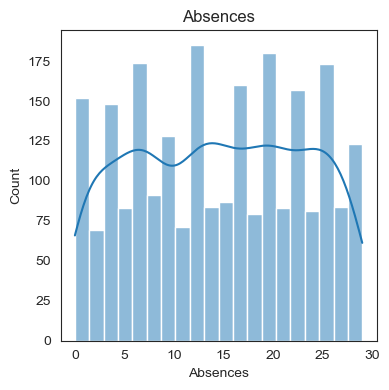

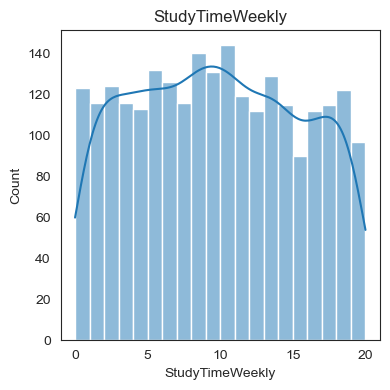

In [58]:
plt.figure(figsize=(4, 4))
sns.histplot(df['Absences'], kde=True, bins=20)
plt.title('Absences')
plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 4))
sns.histplot(df['StudyTimeWeekly'], kde=True, bins=20)
plt.title('StudyTimeWeekly')
plt.tight_layout()
plt.show()

In [59]:

df['Attendance'] = 1 - (df['Absences'] / 30) #basically just the opposite of abscences data shows a max of 30 absences so divide by 30

df['Activity'] = df[['Extracurricular', 'Music', 'Sports', 'Volunteering']].sum(axis=1) #all non academic activities, probably if students are more involved they might do better academically

df['StudyTimeNorm'] = df['StudyTimeWeekly'] / 20 #study time massaged to be between 0 and 1 (data shows a max of 20 hours per week so divide by 20
#here we define the ratios of used features to create the new feature
df['Engagement'] = (
    df['Attendance'] * 0.4 +
    df['Activity'] * 0.3 +
    df['StudyTimeNorm'] * 0.3
)

## Checking for duplicates and viewing all input variables

In [60]:
duplicates = df[df.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [StudentID, Age, Gender, Ethnicity, ParentalEducation, StudyTimeWeekly, Absences, Tutoring, ParentalSupport, Extracurricular, Sports, Music, Volunteering, GPA, GradeClass, Attendance, Activity, StudyTimeNorm, Engagement]
Index: []


In [61]:
#lists input variables
all_vars = df.columns
outputvar_name = 'GradeClass'
inputvar_names = all_vars.drop(outputvar_name).tolist()

df_inputs = df[inputvar_names]
df_output = df[outputvar_name]

print(f'there are {len(inputvar_names)} Input variables')
df_inputs


there are 18 Input variables


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,Attendance,Activity,StudyTimeNorm,Engagement
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,0.766667,1,0.991686,0.904173
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.000000,0,0.770438,0.631131
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,0.133333,0,0.210528,0.116492
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,0.533333,1,0.501441,0.663766
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,0.433333,0,0.233625,0.243421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,3388,18,1,0,3,10.680555,2,0,4,1,0,0,0,3.455509,0.933333,1,0.534028,0.833542
2388,3389,17,0,0,1,7.583217,4,1,4,0,1,0,0,3.279150,0.866667,1,0.379161,0.760415
2389,3390,16,1,0,2,6.805500,20,0,2,0,0,0,1,1.142333,0.333333,1,0.340275,0.535416
2390,3391,16,1,1,0,12.416653,17,0,2,0,1,1,0,1.803297,0.433333,2,0.620833,0.959583


## Heatmap that examines the correlation between inputs and GradeClass

In [62]:
def CorrPlot(df, dropDuplicates = True, figsize = (8, 6)):
    # df = df.corr()
    df = np.abs(df.corr())
    # Exclude duplicate correlations by masking upper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
    # Set background color / chart style
    sns.set_style(style = 'white')
    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                    annot=True,
                    square=True,
                    linewidth=.5, cbar_kws={"shrink": .75}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                annot=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        

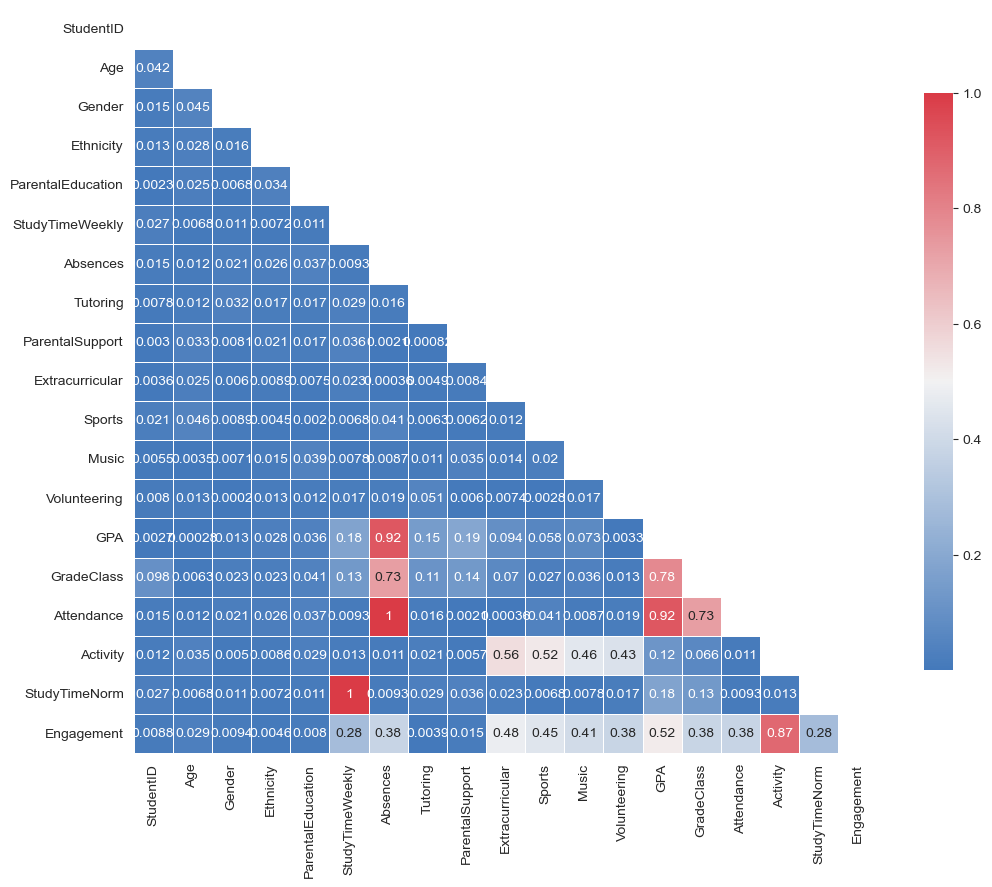

In [63]:
CorrPlot(df, figsize = (12, 10))

## Univariate analysis

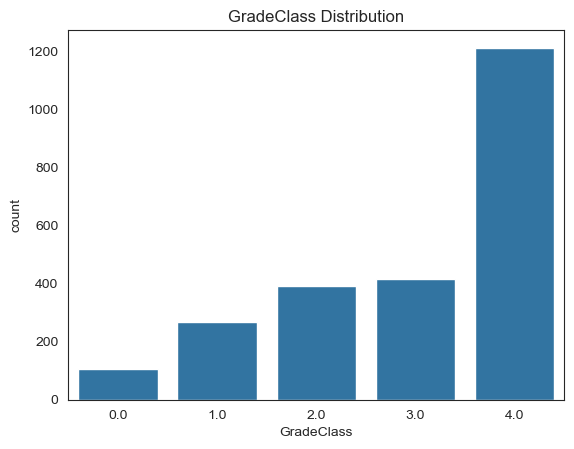

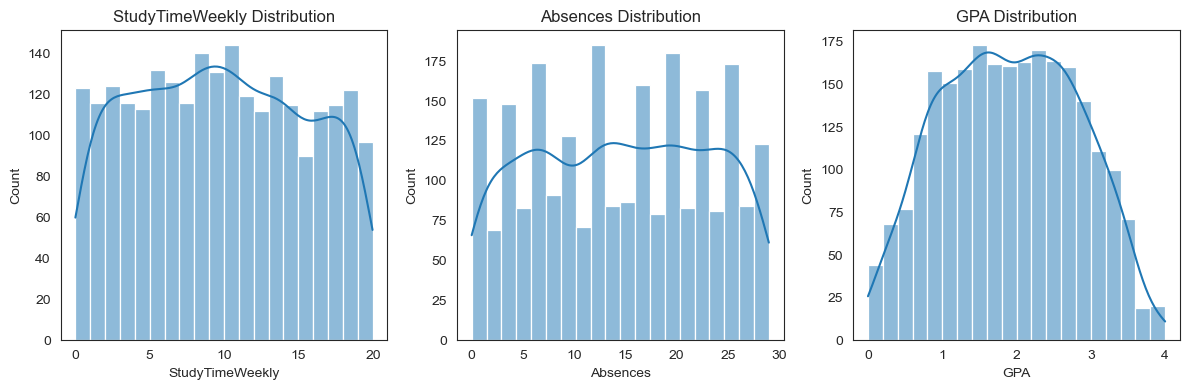

In [64]:
#plots gradeClass
sns.countplot(x='GradeClass', data=df)
plt.title('GradeClass Distribution')
plt.show()

numeric_cols = ['StudyTimeWeekly', 'Absences', 'GPA']

plt.figure(figsize=(12, 4))
for i, col in enumerate(numeric_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

## Bivariate analysis

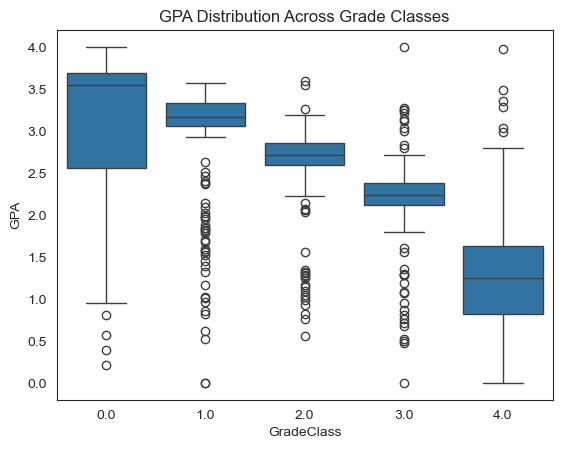

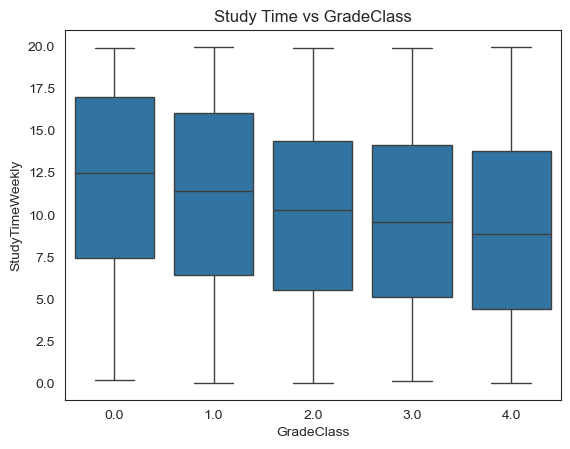

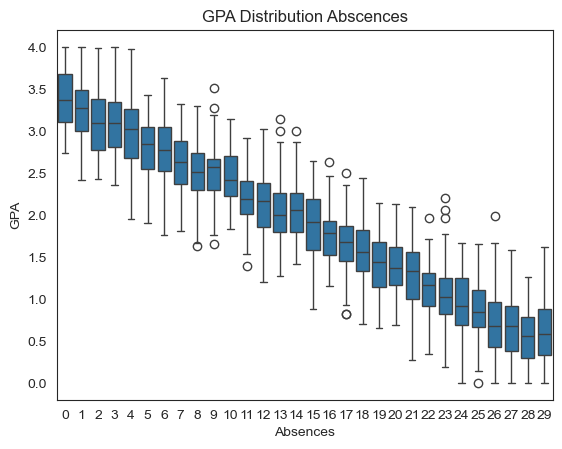

In [65]:
# Boxplot of GPA across GradeClass
sns.boxplot(x='GradeClass', y='GPA', data=df)
plt.title("GPA Distribution Across Grade Classes")
plt.show()

# Barplot: StudyTimeWeekly vs GradeClass
sns.boxplot(x='GradeClass', y='StudyTimeWeekly', data=df)
plt.title("Study Time vs GradeClass")
plt.show()

# Boxplot of GPA across Abscenses
sns.boxplot(x='Absences', y='GPA', data=df)
plt.title("GPA Distribution Abscences")
plt.show()



## Dropping data that wont have an effect on GradeClass

drop GPA because it directly determines grade class

In [66]:
df_cleaned = df.drop(columns=[
    'Age', 'Gender', 'Ethnicity', 'ParentalEducation',
    'Extracurricular', 'Music', 'Volunteering',
    'Sports', 'StudentID', 'GPA', 'StudyTimeNorm', 'Activity', 'Attendance'
])

## Displays all data that wasnt dropped

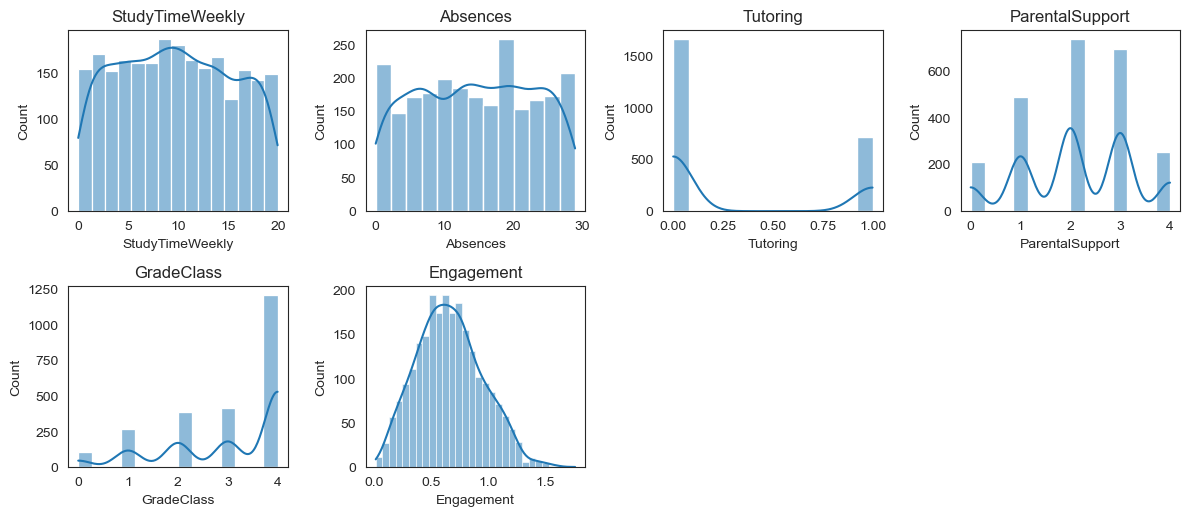

In [67]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(df_cleaned.columns):
    plt.subplot(4, 4, i+1)
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

## Create a function to map GradeClass values to at risk or not

In [68]:
def convert_to_risk(x):
    if x >= 3:
        return 1
    else:
        return 0

df_cleaned['AtRisk'] = df_cleaned['GradeClass'].apply(convert_to_risk)

## More data visualisation

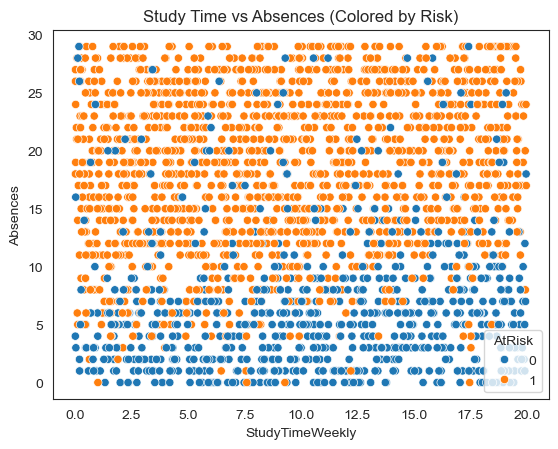

In [69]:
sns.scatterplot(x='StudyTimeWeekly', y='Absences', hue='AtRisk', data=df_cleaned)
plt.title("Study Time vs Absences (Colored by Risk)")
plt.show()

## Outlier treatment

In [70]:
def remove_outliers(df, cols):  #function to remove outliers
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)

        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col]<= upper)]

    return df


df_cleaned = remove_outliers(df_cleaned, ['Absences', 'StudyTimeWeekly', 'ParentalSupport', 'Engagement'])  #calls the function made above

## Splitting data into features and a target

In [71]:
X = df_cleaned.drop(columns=['GradeClass', 'AtRisk'])
y = df_cleaned['AtRisk'] #AtRisk = D or F

## Scaling input data using standard scaler

In [72]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Viewing scaled data

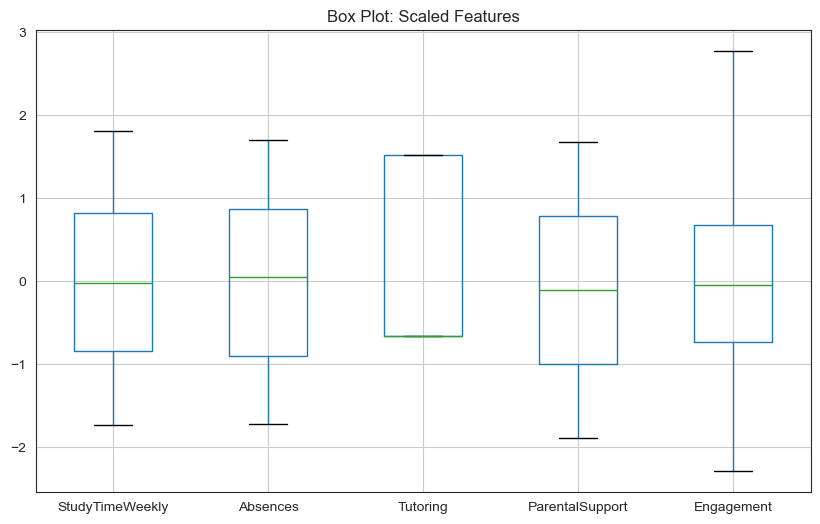

In [73]:
#converts data to df
x_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
#displays scaled features
fig, ax = plt.subplots(figsize=(10, 6))
boxplot = x_scaled_df.boxplot(vert = 1, ax=ax)  
_ = ax.set_title(f'Box Plot: Scaled Features')

## spliting data into training and testing data

In [74]:
# Get the original indices
original_indices = np.arange(len(X_scaled))
# Split indices along with the data
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y, original_indices, test_size=0.2, random_state=95
)

Save the Train and est data to csv files

In [75]:
# Convert to Series and save
train_index = pd.Series(idx_train)
test_index = pd.Series(idx_test)

train_index_path = os.path.join(parent_folder, "Data", "train_index.csv")
test_index_path = os.path.join(parent_folder, "Data", "test_index.csv")

train_index.to_csv(train_index_path, index=False, header=False)
test_index.to_csv(test_index_path, index=False, header=False)

print("Part 1: Train and test indices saved to CSV.")

Part 1: Train and test indices saved to CSV.


## implementing basic ML models

### Logistic regression

In [76]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.90      0.80      0.85       147
           1       0.92      0.96      0.94       329

    accuracy                           0.91       476
   macro avg       0.91      0.88      0.89       476
weighted avg       0.91      0.91      0.91       476



### Random Forest

In [77]:
rf = RandomForestClassifier(n_estimators=100, random_state=101)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Report:
               precision    recall  f1-score   support

           0       0.90      0.79      0.84       147
           1       0.91      0.96      0.93       329

    accuracy                           0.91       476
   macro avg       0.90      0.87      0.89       476
weighted avg       0.91      0.91      0.91       476



# Dumps trained model and scaler for use in dash app

In [78]:
joblib.dump(rf, '../Deployment/model.pkl')         # Save trained model and scaler
joblib.dump(scaler, '../Deployment/scaler.pkl') 

['../Deployment/scaler.pkl']

### Random Forest importance

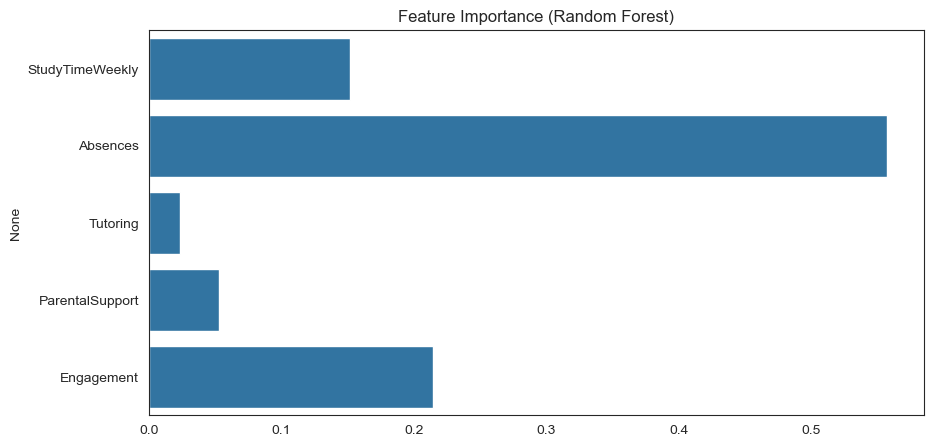

In [79]:
importances = rf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance (Random Forest)')
plt.show()

### XGBoost

In [80]:
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print('XGBoost:\n', classification_report(y_test, y_pred_xgb))

XGBoost:
               precision    recall  f1-score   support

           0       0.88      0.75      0.81       147
           1       0.89      0.95      0.92       329

    accuracy                           0.89       476
   macro avg       0.89      0.85      0.87       476
weighted avg       0.89      0.89      0.89       476



# Predict if a student is at risk using random forest

In [81]:
new_student = {
    'StudyTimeWeekly': 5,
    'Absences': 13,
    'Tutoring': 1,
    'ParentalSupport': 3,
    'Engagement': 0.7 #engineered feature
}

new_df = pd.DataFrame([new_student]) #convert array to df

new_df_scaled = scaler.transform(new_df) #scaled same way as dataset

prediction = rf.predict(new_df_scaled) 
print("Prediction:", "At Risk" if prediction[0] == 1 else "Not At Risk")

proba = rf.predict_proba(new_df_scaled)
print(f"Probability of being at risk: {proba[0][1]*100:.2f}%")

Prediction: At Risk
Probability of being at risk: 60.00%
